## Parking Controller via MPC with Obstacles

###System dynamics:
\begin{align}
\dot{x}	&=&	Vcos(\phi+\beta)\\
\dot{y}	&=&	Vsin(\phi+\beta)\\
\dot{\phi}	&=&	V/l sin(\beta)\\
\dot{V}	&=&	a
\end{align}
Here $a$ is the center of mass acceleration
$z = [x,y,\phi,V]$, $u = [\beta, a]$


In [2]:
#Pkg.add("JuMP"); Pkg.add("Ipopt"); Pkg.add("Gadfly"); Pkg.add("Interact")
#Pkg.checkout("JuMP") # need latest master for matrices
using JuMP, Ipopt
using PyPlot
#using ODE
using PyCall

function solveMPC(l,w,n,m,T,z0,zT,zmin,zmax,umax,dt,Nb,obs)
    mpc = Model(solver=IpoptSolver(print_level=0))
    @defVar(mpc,  zmin[i] <= z[i=1:n,t=0:T] <= zmax[i])
    @defVar(mpc, -umax[i] <= u[i=1:m,t=0:T] <= umax[i])
    # Cost
    #@setObjective(mpc, Min,
    #    sum{100*(z[1,t]+z[2,t]+z[3,t]+z[4,t])^2 + sum{u[j,t]^2,j=1:m},t=0:T})
    @setObjective(mpc, Min,
    sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+100*(z[3,T]-zT[3])^2,t=T-4:T})
    
    # Link state and control across the horizon
    for t = 0:T-1        
        @addNLConstraint(mpc, z[1,t+1] == z[1,t] + dt*z[4,t]*cos(z[3,t]+u[1,t]))
        @addNLConstraint(mpc, z[2,t+1] == z[2,t] + dt*z[4,t]*sin(z[3,t]+u[1,t]))
        @addNLConstraint(mpc, z[3,t+1] == z[3,t] + dt*z[4,t]/l*sin(u[1,t]))
        @addNLConstraint(mpc, z[4,t+1] == z[4,t] + dt*u[2,t])
        # Blocking Move (quick/dirty version)
        if (t>0) && (rem(t,Nb)!=0)
            print("-Added BL move constraint-")
            @addConstraint(mpc, u[:,t] .== u[:,t-1])
        end
    end

    # Obstacle avoidance constraints 
    if 0<1
        @defVar(mpc, lambda[i=1:16,t=0:T] >= 0)
        #for t = 0:Nb:T-1 
        for t = 0:T-1 
            # Four corners of the car
            #A=[x+l*cos(psi)+w*sin(psi),y+l*sin(psi)-w*cos(psi)]
            #B=[x-l*cos(psi)+w*sin(psi),y-l*sin(psi)-w*cos(psi)]
            #C=[x+l*cos(psi)-w*sin(psi),y+l*sin(psi)+w*cos(psi)]
            #D=[x-l*cos(psi)-w*sin(psi),y-l*sin(psi)+w*cos(psi)]

            #To be parametrized later : parallel parking bay with two obstacles
            # x>=xl OR y-yt>=0 
            # x<=xr OR y-yt>=0 
            # Evaluated at A,B,C,D
            xl=obs[1]
            xr=obs[2]
            yt=obs[3]

            @addNLConstraint(mpc, lambda[1,t]*(z[1,t]+l*cos(z[3,t])+w*sin(z[3,t])-xl)+lambda[2,t]*(z[2,t]+l*sin(z[3,t])-w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[1,t]+lambda[2,t] == 1)
            @addNLConstraint(mpc, lambda[3,t]*(z[1,t]-l*cos(z[3,t])+w*sin(z[3,t])-xl)+lambda[4,t]*(z[2,t]-l*sin(z[3,t])-w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[3,t]+lambda[4,t] == 1)
            @addNLConstraint(mpc, lambda[5,t]*(z[1,t]+l*cos(z[3,t])-w*sin(z[3,t])-xl)+lambda[6,t]*(z[2,t]+l*sin(z[3,t])+w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[5,t]+lambda[6,t] == 1)
            @addNLConstraint(mpc, lambda[7,t]*(z[1,t]-l*cos(z[3,t])-w*sin(z[3,t])-xl)+lambda[8,t]*(z[2,t]-l*sin(z[3,t])+w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[7,t]+lambda[8,t] == 1)

            @addNLConstraint(mpc, lambda[9,t]*(-(z[1,t]+l*cos(z[3,t])+w*sin(z[3,t]))+xr)+lambda[10,t]*(z[2,t]+l*sin(z[3,t])-w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[9,t]+lambda[10,t] == 1)
            @addNLConstraint(mpc, lambda[11,t]*(-(z[1,t]-l*cos(z[3,t])+w*sin(z[3,t]))+xr)+lambda[12,t]*(z[2,t]-l*sin(z[3,t])-w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[11,t]+lambda[12,t] == 1)
            @addNLConstraint(mpc, lambda[13,t]*(-(z[1,t]+l*cos(z[3,t])-w*sin(z[3,t]))+xr)+lambda[14,t]*(z[2,t]+l*sin(z[3,t])+w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[13,t]+lambda[14,t] == 1)
            @addNLConstraint(mpc, lambda[15,t]*(-(z[1,t]-l*cos(z[3,t])-w*sin(z[3,t]))+xr)+lambda[16,t]*(z[2,t]-l*sin(z[3,t])+w*cos(z[3,t])-yt) >=0)
            @addConstraint(mpc, lambda[15,t]+lambda[16,t] == 1)

        end
    end

    # Initial conditions
    @addConstraint(mpc, z[:,0] .== z0)
    # Final state
    #@addConstraint(mpc, z[:,T] .== zT)
    # Solve the NLP
    solve(mpc)
    # Return the control plan
    # return getValue(u[:,0])
    #return getValue(u[:,0]), getValue(z[:,1])
    return getValue(u), getValue(z)
end

INFO: Loading help data...


solveMPC (generic function with 1 method)

In [3]:
function zdot_fun(z,u,l)
    beta=u[1]
    a=u[2]
    phi=z[3]
    V=z[4]
    xdot=V*cos(phi+beta)
    ydot=V*sin(phi+beta)
    phidot=V/l*sin(beta)
    Vdot=a                      
    zdot = [xdot;ydot;phidot;Vdot]
    return zdot
end


function simulate_car_MPC(T,Tsim,Tr,z0,zT,zmax,umax,l,n,m,dt)
    u_history = zeros(m,Tsim)
    z_history = zeros(n,Tsim)
    z_t = z0[:]
    for t = 0:Tr:Tsim-1
        # SHRINKING HORIZON MPC
        u_vec, z_vec= solveMPC(l,n,m,T-t,z_t,zT,zmax,umax,dt)
        print("-MPC solved-")
        for k = 1:min(Tr,length(u_vec))
              u_t=u_vec[:,k]
              z_history[:,t+k] = z_t[:]
              u_history[:,t+k] = u_t[:]
              z_t = z_t + dt*zdot_fun(z_t,u_t,l)
        end
    end
    return  u_history, z_history
end



simulate_car_MPC (generic function with 1 method)

### Run Simulations

In [4]:
#Car Lengths to be fixed later
l = 1.738
width=0.93
n=4
m=2

# Case close to parking, NOTE weiht 10 on angle: weight[1,1,10,1]
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [-1;6;0;0]  
zT = [0;1.5;pi;0]  
obs=[-3.5;3.5;3]
zmax=[20;10;pi;10]
zmin=[-20;0;-pi;-10]
T = 60 # MPC horizon
dt=0.5
umax=[0.6;1.5*dt]
Nb=1

# Case exiting parking one side
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;pi/2;0]  
zT = [-2;8;pi;0]  
obs=[-2.5;2.5;6]
zmax=[20;20;pi;10]
zmin=[-20;0;-pi;-10]
T = 30 # MPC horizon
dt=0.5
umax=[0.6;1.5*dt]
Nb=1

# Case exiting parking other side
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;-pi/2;0]  
zT = [-2;8;-pi;0]  
obs=[-2.5;2.5;6]
zmax=[20;9.5;2*pi;10]
zmin=[-20;0;-2*pi;-10]
T = 200 # MPC horizon
dt=0.2
umax=[0.6;1.5*dt]
Nb=1

# Case exiting parking other side
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+100*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;-pi/2;0]  
zT = [-3;8;-pi;0]  
obs=[-2.5;2.5;6]
zmax=[20;9.5;2*pi;10]
zmin=[-20;0;-2*pi;-10]
T = 60 # MPC horizon
dt=0.2
umax=[0.6;1.5*dt]
Nb=1

# Case exiting parking other side -> Good for SLIDES
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;-pi/2;0]  
zT = [-3;8;-pi;0]  
obs=[-1.5;2.5;6]
zmax=[20;9.5;2*pi;10]
zmin=[-20;0;-2*pi;-10]
T = 80 # MPC horizon TO 110
dt=0.2
umax=[0.6;1.5*dt]
Nb=1


# Case exiting parking other side -> Good fro SLIDES
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;-pi/2;0]  
zT = [-3;8;-pi;0]  
obs=[-1.5;2.5;6]
zmax=[20;8.5;2*pi;10]
zmin=[-20;0;-2*pi;-10]
T = 95 # MPC horizon
dt=0.2
umax=[0.6;1.5*dt]
Nb=1


# Case exiting parking other side -> Good fro SLIDES
#sum{(z[1,T]-zT[1])^2+(z[2,T]-zT[2])^2+10*(z[3,T]-zT[3])^2+(z[4,T]-zT[4])^2,t=T-4:T})
z0 = [0;3;-pi/2+pi/10;0]  
zT = [0;8.0;-pi;0]    
obs=[-1.5;2.5;6]
zmax=[20;7.5;2*pi;10]
zmin=[-20;2.3;-2*pi;-10]
T = 70# MPC horizon
T = 110# MPC horizon
T = 102# MPC horizon
dt=0.2
umax=[0.6;1.5*dt]
Nb=1

# Closed- Loop MPC, NOT TESTED FOR NOW
#u_vec,z_vec = simulate_car_MPC(T,Tsim,Treplanning,z0,zT,zmax,umax,l,n,m,dt)

# Open Loop MPC
u_vec, z_vec= solveMPC(l,width,n,m,T,z0,zT,zmin,zmax,umax,dt,Nb,obs)





(u: 2 dimensions:
[1,:]
  [1,  0] = -4.9639884241464264e-17
  [1,  1] = -0.5999988559596175
  [1,  2] = -0.5999994759291144
  [1,  3] = -0.5999996909871694
  [1,  4] = -0.5999998003847969
  [1,  5] = -0.5999997992425766
  [1,  6] = -0.5999997388985275
  [1,  7] = -0.599999584976559
  [1,  8] = -0.5999988388099763
  [1,  9] = 0.5999991235984349
  [1, 10] = 0.5999997309329749
  [1, 11] = 0.5999998392673169
  [1, 12] = 0.5999998822696627
  [1, 13] = 0.5999999033604223
  [1, 14] = 0.5999999136544001
  [1, 15] = 0.5999999166344366
  [1, 16] = 0.5999999124037853
  [1, 17] = 0.5999998971521691
  [1, 18] = 0.599999854536884
  [1, 19] = 0.5999996576493135
  [1, 20] = 0.12086761149934575
  [1, 21] = 1.616176070242514e-8
  [1, 22] = -6.941475989150913e-8
  [1, 23] = -2.753474174254693e-7
  [1, 24] = -0.053376294056021144
  [1, 25] = -0.39346217535100014
  [1, 26] = -0.5596028997183805
  [1, 27] = -0.5999990245910387
  [1, 28] = -0.5999995076205725
  [1, 29] = -0.599999632480214
  [1, 30] = -0.599

###Next cell plots the parking manouver

[1.4675922725528094
 7.5
 -3.0998919232664175
 -1.8170830168930658]

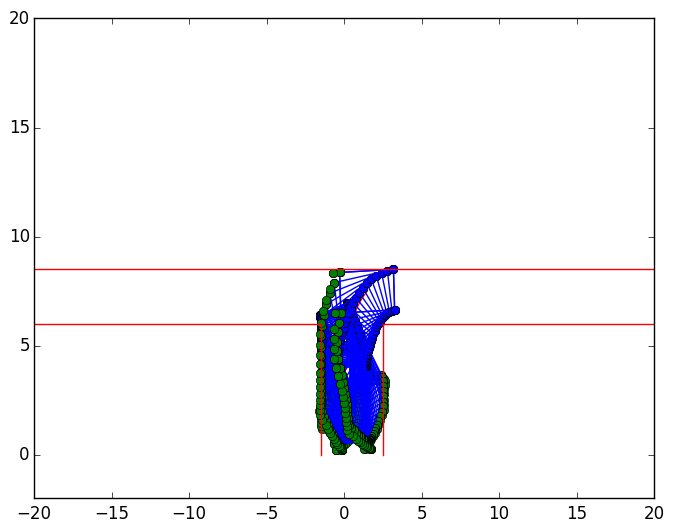

In [5]:
@pyimport matplotlib.pyplot as plt
print(z_vec[:,[end]])

#Find Axis Limits
xmin = minimum([z_vec[1,:]])
xmax = maximum([z_vec[1,:]])
xmin, xmax = xmin - 0.1(xmax-xmin), xmax+ 0.1*(xmax-xmin)
ymin = minimum([z_vec[2,:]])
ymax = maximum([z_vec[2,:]])
ymin, ymax = ymin - 0.1(ymax-ymin), ymax+ 0.1*(ymax-ymin)

function plot_car(x,y,psi,beta,l,w,pt)
    A=[x+l*cos(psi)+w*sin(psi),y+l*sin(psi)-w*cos(psi)]
    B=[x-l*cos(psi)+w*sin(psi),y-l*sin(psi)-w*cos(psi)]
    C=[x+l*cos(psi)-w*sin(psi),y+l*sin(psi)+w*cos(psi)]
    D=[x-l*cos(psi)-w*sin(psi),y-l*sin(psi)+w*cos(psi)]
    #wheels
    lw=0.4
    E=[A[1]+lw*cos(psi+beta),A[2]+lw*sin(psi+beta)]
    F=[C[1]+lw*cos(psi+beta),C[2]+lw*sin(psi+beta)]
    
    pt.plot([B[1] ,A[1]],[B[2], A[2]],"bo-")
    pt.plot([C[1] ,D[1]],[C[2], D[2]],"bo-")
    pt.plot([C[1] ,A[1]],[C[2], A[2]],"bo-")
    pt.plot([B[1] ,D[1]],[B[2], D[2]],"bo-")
    pt.plot([A[1] ,E[1]],[A[2], E[2]],"go-")
    pt.plot([C[1] ,F[1]],[C[2], F[2]],"go-")
end


#Construct Figure and Plot Data
fig = figure()
ax = plt.axes()
ax = plt.axes(xlim = (-20,20),ylim=(-2,20))
#ax = plt.axes(xlim = (xmin,xmax),ylim=(ymin,ymax))
plt.plot(transpose(z_vec[1,:]),transpose(z_vec[2,:]), "r-")

#Plot sow in TIME
for i=1:1:T
    plot_car(z_vec[1,i],z_vec[2,i],z_vec[3,i],u_vec[1,i],l,width,plt)
end
plot_car(z_vec[1,[end]],z_vec[2,[end]],z_vec[3,[end]],u_vec[1,[end]],l,width,plt)



##end#Plot in SPACE
#NtP=6
#u_history = zeros(m,NtP*Tsim)
#z_history = zeros(n,NtP*Tsim)
#k=1
#for i=1:T
#    z_t=z_vec[:,i]
#    u_t=u_vec[:,i]
#    ddt=0.#5
 #   for j=0:ddt:dt
#        plot_car(z_t[1],z_t[2],z_t[3],u_t[1],l,width,plt)
#        z_history[:,k] = z_t[:]
 #       u_history[:,k] = u_t[:]
 #       z_t = z_t + ddt*zdot_fun(z_t,u_t,l)
 #       k=k+1
 #   en#d
#end
plt.plot([obs[1] ,obs[1]],[0, obs[3]],"r-")
plt.plot([obs[2] ,obs[2]],[0, obs[3]],"r-")
plt.plot([-20 ,obs[1]],[obs[3], obs[3]],"r-")
plt.plot([obs[2] ,20],[obs[3], obs[3]],"r-")
plt.plot([-20 ,20],[zmax[2]+1, zmax[2]+1],"r-")
plt.show()


#Plot start and end points
#ax[:plot](z_vec[1,1],z_vec[2,1], "ro")
#ax[:plot](z_vec[1,end],z_vec[2,end], "rs")

### Next makes a video of the manouver

In [9]:
#Pkg.add("PyPlot")
#Pkg.add("PyCall")
#Pkg.add("VideoIO")
using PyPlot
using PyCall
@pyimport matplotlib.animation as anim


pygui(true)

# First set up the figure, the axis, and the plot element we want to animate
fig = figure()
#ax = plt.axes(xlim = (xmin,xmax),ylim=(ymin,ymax))
#ax = plt.axes(xlim=(-10, 5), ylim=(-2, 10))
ax = plt.axes(xlim=(-5, 5), ylim=(-0, 10))
#ax2 = plt.axes()
global line1 = ax[:plot]([], [], "ro-")[1]
global line2 = ax[:plot]([], [], "ro-")[1]
global line3 = ax[:plot]([], [], "ro-")[1]
global line4 = ax[:plot]([], [], "ro-")[1]
global line5 = ax[:plot]([], [], "go-")[1]
global line6 = ax[:plot]([], [], "go-")[1]
ax[:plot]([obs[1] ,obs[1]],[0, obs[3]],"r-")
ax[:plot]([obs[2] ,obs[2]],[0, obs[3]],"r-")
ax[:plot]([-20 ,obs[1]],[obs[3], obs[3]],"r-")
ax[:plot]([obs[2] ,20],[obs[3], obs[3]],"r-")
ax[:plot]([-20 ,20],[zmax[2]+1, zmax[2]+1],"r-")
#plt.plot([-3 ,-3],[-3, 0],"r-")
#plt.plot([3 ,3],[-3, 0],"r-")
#plt.plot([-10 ,-3],[0, 0],"r-")
#plt.plot([3 ,15],[0, 0],"r-")

function points_car(x,y,psi,beta,l,w)
    A=[x+l*cos(psi)+w*sin(psi),y+l*sin(psi)-w*cos(psi)]
    B=[x-l*cos(psi)+w*sin(psi),y-l*sin(psi)-w*cos(psi)]
    C=[x+l*cos(psi)-w*sin(psi),y+l*sin(psi)+w*cos(psi)]
    D=[x-l*cos(psi)-w*sin(psi),y-l*sin(psi)+w*cos(psi)]
    #wheels
    lw=0.6
    E=[A[1]+lw/2*cos(psi+beta),A[2]+lw/2*sin(psi+beta)]
    F=[C[1]+lw/2*cos(psi+beta),C[2]+lw/2*sin(psi+beta)]
    G=[A[1]-lw/2*cos(psi+beta),A[2]-lw/2*sin(psi+beta)]
    H=[C[1]-lw/2*cos(psi+beta),C[2]-lw/2*sin(psi+beta)]
    return A,B,C,D,E,F,G,H
end
 

# initialization function: plot the background of each frame
function init()
    global line1
    global line2
    global line3
    global line4
    global line5
    global line6
    global line7
    line1[:set_data]([], [])
    line2[:set_data]([], [])
    line3[:set_data]([], [])
    line4[:set_data]([], [])
    line5[:set_data]([], [])
    line6[:set_data]([], [])
    return (line1,line2,line3,line4,line5,line6,None)
end

# animation function.  This is called sequentially
function animate(i)
    k=i+1
    global line1
    global line2
    global line3
    global line4
    global line5
    global line6
    global line7
    if k<=T
        A,B,C,D,E,F,G,H=points_car(z_vec[1,k],z_vec[2,k],z_vec[3,k],u_vec[1,k],l,width)
    else
        A,B,C,D,E,F,G,H=points_car(z_vec[1,T],z_vec[2,T],z_vec[3,T],u_vec[1,T],l,width)
    end
    line1[:set_data]([B[1] ,A[1]],[B[2], A[2]])
    line2[:set_data]([C[1] ,D[1]],[C[2], D[2]])
    line3[:set_data]([C[1] ,A[1]],[C[2], A[2]])
    line4[:set_data]([B[1] ,D[1]],[B[2], D[2]])
    line5[:set_data]([G[1] ,E[1]],[G[2], E[2]])
    line6[:set_data]([H[1] ,F[1]],[H[2], F[2]])
    return (line1,line2,line3,line4,line5,line6,None)
end


# call the animator.  blit=True means only re-draw the parts that have changed.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=T+20,  interval=100,)
myanim[:save]("parking.mp4", writer="ffmpeg",  extra_args=["-vcodec", "libx264"])
myanim[:save]("parking2.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])


LoadError: key not found: "Rectangle"
while loading In[9], in expression starting on line 23